In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/IRP/irp-hz122

/content/drive/MyDrive/IRP/irp-hz122


In [3]:
! pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 4.7 MB/s eta 0:00:00


In [4]:
from models import dataloader, model, results_plot
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from ignite.metrics import SSIM

In [5]:
device = 'cuda'

In [6]:
# Set parameters
lookback = 3
lookahead = 3
batch_size = 20
num_epochs = 30

# Burgers' Equation

## load data

In [7]:
test_data = torch.from_numpy(np.load('data/test_burger_high_10_100_rm20.npy')).to(device).float()
b, s, c, w, h = test_data.shape

# test_data = dataloader.load_data('data/test_burger_high_10_100_rm20.npy', model='LSTM')

In [8]:
initial_predict_data = test_data[:,:3,:]

## Set MSPC-LSTM

In [9]:
# high-fidelity CAE
class HighEncoder(nn.Module):
    def __init__(self):
        super(HighEncoder, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, stride=2, padding=1)  # output size: 65x65
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # output size: 33x33
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # output size: 17x17
        self.fc = nn.Linear(128*17*17, 512)  # Flatten and apply dense layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)  # Apply dense layer
        return x


class HighDecoder(nn.Module):
    def __init__(self):
        super(HighDecoder, self).__init__()
        self.fc = nn.Linear(512, 128*17*17)  # Dense layer
        self.t_conv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # output size: 33x33
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)  # output size: 65x65
        self.t_conv3 = nn.ConvTranspose2d(32, 2, 3, stride=2, padding=1, output_padding=1)  # output size: 129x129

    def forward(self, x):
        x = self.fc(x)  # Apply dense layer
        x = x.view(x.size(0), 128, 17, 17)  # Reshape the tensor
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = self.t_conv3(x)  # No activation here
        x = x[:, :, 3:132, 3:132]  # Trim the tensor to the correct size
        return x


class HighCAE(nn.Module):
    def __init__(self):
        super(HighCAE, self).__init__()
        self.encoder = HighEncoder()
        self.decoder = HighDecoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
class LowEncoder(nn.Module):
    def __init__(self):
        super(LowEncoder, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, 3, stride=2, padding=1)  # output size: 17x17
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # output size: 9x9
        self.fc = nn.Linear(32*9*9, 512)  # Flatten and apply dense layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)  # Apply dense layer
        return x


class LowDecoder(nn.Module):
    def __init__(self):
        super(LowDecoder, self).__init__()
        self.fc = nn.Linear(512, 32*9*9)  # Dense layer
        self.t_conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)  # output size: 17x17
        self.t_conv2 = nn.ConvTranspose2d(16, 2, 3, stride=2, padding=1, output_padding=1)  # output size: 33x33

    def forward(self, x):
        x = self.fc(x)  # Apply dense layer
        x = x.view(x.size(0), 32, 9, 9)  # Reshape the tensor
        x = F.relu(self.t_conv1(x))
        x = self.t_conv2(x)  # No activation here
        x = x[:, :, 1:34, 1:34] # Trim the tensor to the correct size
        return x

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Seq2Seq, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # we only want the last 3 time steps

        return out

In [14]:
# initialize basic MSPC-LSTM
HF_CAE = torch.load("model_paths/burger_highcae_512.pth")
LF_CAE = torch.load("model_paths/burger_lowcae_512.pth")
basic_LSTM = torch.load("model_paths/burger_basic_lstm.pth")
burger_basic_MSPC = model.Burgers_MSPC_LSTM(HF_CAE, LF_CAE, basic_LSTM)

muldata_LSTM = torch.load("model_paths/burger_lstm_multidata.pth")
burger_multidata_MSPC = model.Burgers_MSPC_LSTM(HF_CAE, LF_CAE, muldata_LSTM)

In [15]:
# initialize energy constraint MSPC-LSTM
ec_high_LSTM = torch.load("model_paths/burger_lstm_high_ec.pth")
burger_hf_ec_MSPC = model.Burgers_MSPC_LSTM(HF_CAE, LF_CAE, ec_high_LSTM)

ec_low_LSTM = torch.load("model_paths/burger_lstm_low_ec.pth")
burger_lf_ec_MSPC = model.Burgers_MSPC_LSTM(HF_CAE, LF_CAE, ec_low_LSTM)

In [16]:
# initialize flow operator MSPC-LSTM
fo_high_LSTM = torch.load("model_paths/burger_lstm_high_fo.pth")
burger_hf_fo_MSPC = model.Burgers_MSPC_LSTM(HF_CAE, LF_CAE, fo_high_LSTM)

fo_low_LSTM = torch.load("model_paths/burger_lstm_low_fo.pth")
burger_lf_fo_MSPC = model.Burgers_MSPC_LSTM(HF_CAE, LF_CAE, fo_low_LSTM)

In [17]:
# initialize multiple constraints MSPC-LSTM
multi_high_LSTM = torch.load("model_paths/burger_lstm_high_multi.pth")
burger_hf_multi_MSPC = model.Burgers_MSPC_LSTM(HF_CAE, LF_CAE, multi_high_LSTM)

multi_low_LSTM = torch.load("model_paths/burger_lstm_low_multi.pth")
burger_lf_multi_MSPC = model.Burgers_MSPC_LSTM(HF_CAE, LF_CAE, multi_low_LSTM)

## Predict

In [18]:
# predict results
basic_predictions = burger_basic_MSPC.predict(initial_predict_data, 3, 32)
multidata_predictions = burger_multidata_MSPC.predict(initial_predict_data, 3, 32)
hf_ec_predictions = burger_hf_ec_MSPC.predict(initial_predict_data, 3, 32)
lf_ec_predictions = burger_lf_ec_MSPC.predict(initial_predict_data, 3, 32)
hf_fo_predictions = burger_hf_fo_MSPC.predict(initial_predict_data, 3, 32)
lf_fo_predictions = burger_lf_fo_MSPC.predict(initial_predict_data, 3, 32)
hf_multi_predictions = burger_hf_multi_MSPC.predict(initial_predict_data, 3, 32)
lf_multi_predictions = burger_lf_multi_MSPC.predict(initial_predict_data, 3, 32)

## Evaluate Predictions

In [19]:
reconstructed_data = HF_CAE(test_data.view(-1,2,129,129)).reshape(10,100,2,129,129)

In [20]:
basic_loss, basic_std = results_plot.get_seperate_loss_std(basic_predictions, test_data)
multidata_loss, multidata_std = results_plot.get_seperate_loss_std(multidata_predictions, test_data)
hf_ec_loss, hf_ec_std = results_plot.get_seperate_loss_std(hf_ec_predictions, test_data)
lf_ec_loss, lf_ec_std = results_plot.get_seperate_loss_std(lf_ec_predictions, test_data)
hf_fo_loss, hf_fo_std = results_plot.get_seperate_loss_std(hf_fo_predictions, test_data)
lf_fo_loss, lf_fo_std = results_plot.get_seperate_loss_std(lf_fo_predictions, test_data)
hf_multi_loss, hf_multi_std = results_plot.get_seperate_loss_std(hf_multi_predictions, test_data)
lf_multi_loss, lf_multi_std = results_plot.get_seperate_loss_std(lf_multi_predictions, test_data)

In [21]:
ssim = SSIM(data_range=1.0)
basic_ssim = results_plot.calculate_ssim(basic_predictions, reconstructed_data, ssim)
multidata_ssim = results_plot.calculate_ssim(multidata_predictions, reconstructed_data, ssim)
hf_ec_ssim = results_plot.calculate_ssim(hf_ec_predictions, reconstructed_data, ssim)
lf_ec_ssim = results_plot.calculate_ssim(lf_ec_predictions, reconstructed_data, ssim)
hf_fo_ssim = results_plot.calculate_ssim(hf_fo_predictions, reconstructed_data, ssim)
lf_fo_ssim = results_plot.calculate_ssim(lf_fo_predictions, reconstructed_data, ssim)
hf_multi_ssim = results_plot.calculate_ssim(hf_multi_predictions, reconstructed_data, ssim)
lf_multi_ssim = results_plot.calculate_ssim(lf_multi_predictions, reconstructed_data, ssim)

## plot results

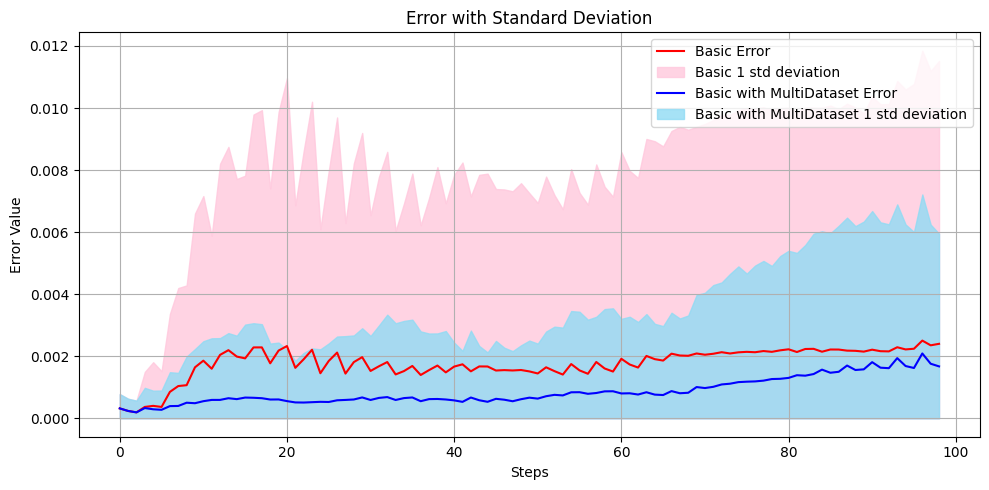

In [23]:
# basic model and multi data basic model
x = np.arange(len(basic_loss))
y_values = [np.array(basic_loss), np.array(multidata_loss)]  # Add more error lists as needed
std_values = [np.array(basic_std), np.array(multidata_std)]    # Add more std lists as needed
labels = ['Basic', 'Basic with MultiDataset']  # Add more labels as needed

results_plot.plot_errors_with_std(x, y_values, std_values, labels)

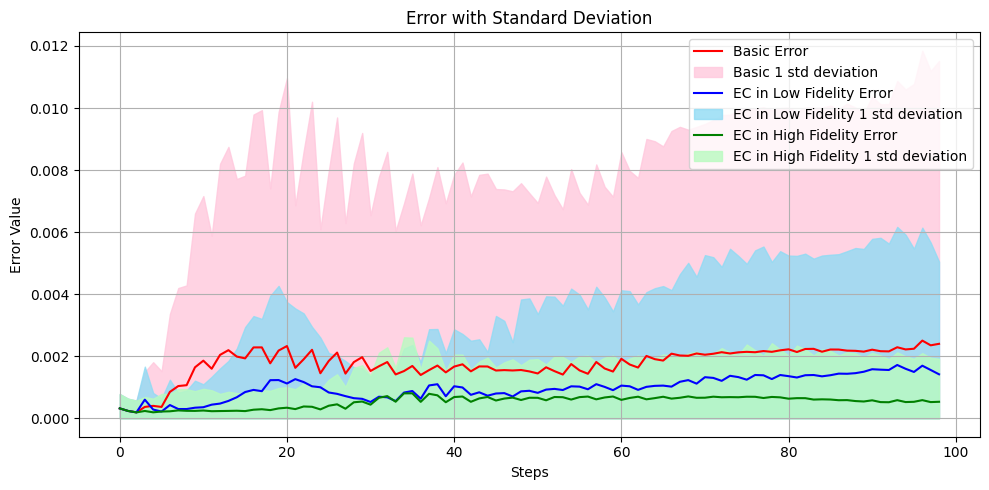

In [24]:
x = np.arange(len(lf_ec_loss))
y_values = [np.array(basic_loss), np.array(lf_ec_loss), np.array(hf_ec_loss)]  # Add more error lists as needed
std_values = [np.array(basic_std), np.array(lf_ec_std), np.array(hf_ec_std)]    # Add more std lists as needed
labels = ['Basic', 'EC in Low Fidelity', 'EC in High Fidelity']  # Add more labels as needed

results_plot.plot_errors_with_std(x, y_values, std_values, labels)

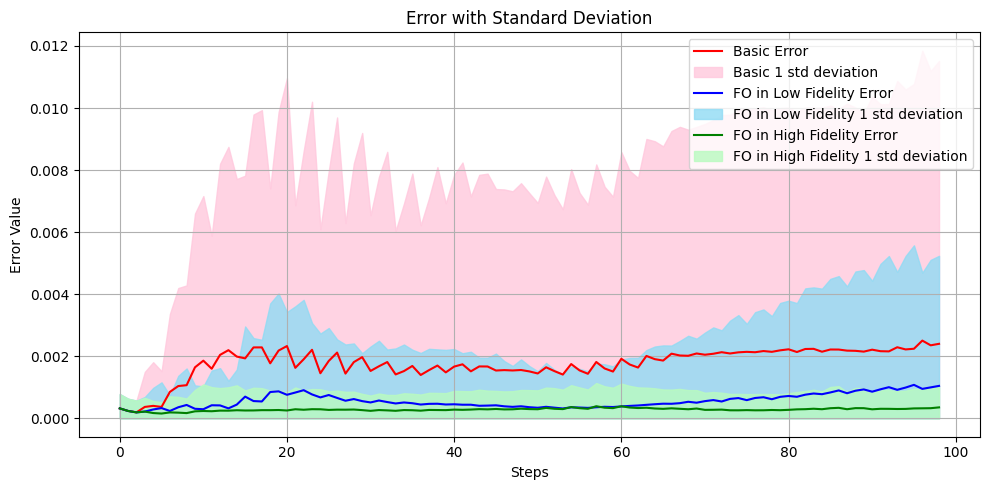

In [25]:
x = np.arange(len(lf_fo_loss))
y_values = [np.array(basic_loss), np.array(lf_fo_loss), np.array(hf_fo_loss)]  # Add more error lists as needed
std_values = [np.array(basic_std), np.array(lf_fo_std), np.array(hf_fo_std)]    # Add more std lists as needed
labels = ['Basic', 'FO in Low Fidelity', 'FO in High Fidelity']  # Add more labels as needed

results_plot.plot_errors_with_std(x, y_values, std_values, labels)

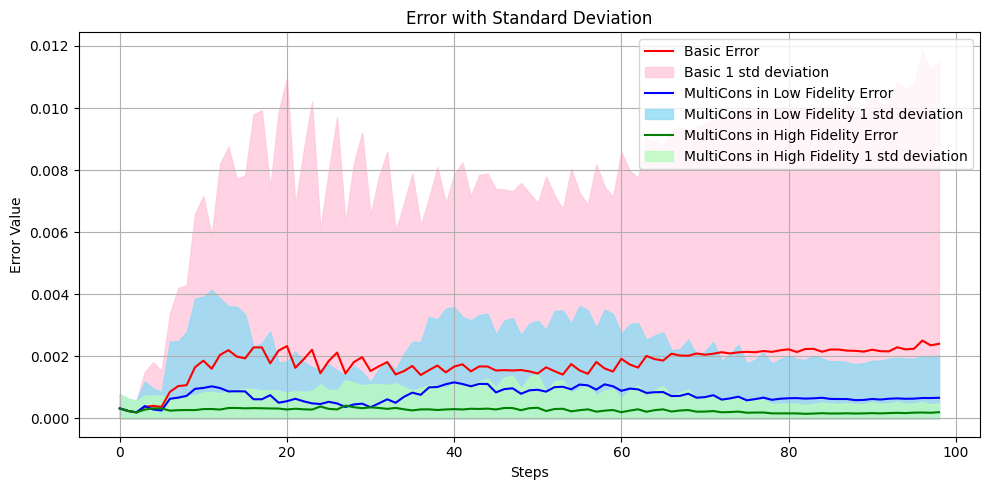

In [26]:
x = np.arange(len(lf_fo_loss))
y_values = [np.array(basic_loss), np.array(lf_multi_loss), np.array(hf_multi_loss)]  # Add more error lists as needed
std_values = [np.array(basic_std), np.array(lf_multi_std), np.array(hf_multi_std)]    # Add more std lists as needed
labels = ['Basic', 'MultiCons in Low Fidelity', 'MultiCons in High Fidelity']  # Add more labels as needed

results_plot.plot_errors_with_std(x, y_values, std_values, labels)

In [27]:
nDisplay = 4
num = [24,49,74,98]
batch_num = 0

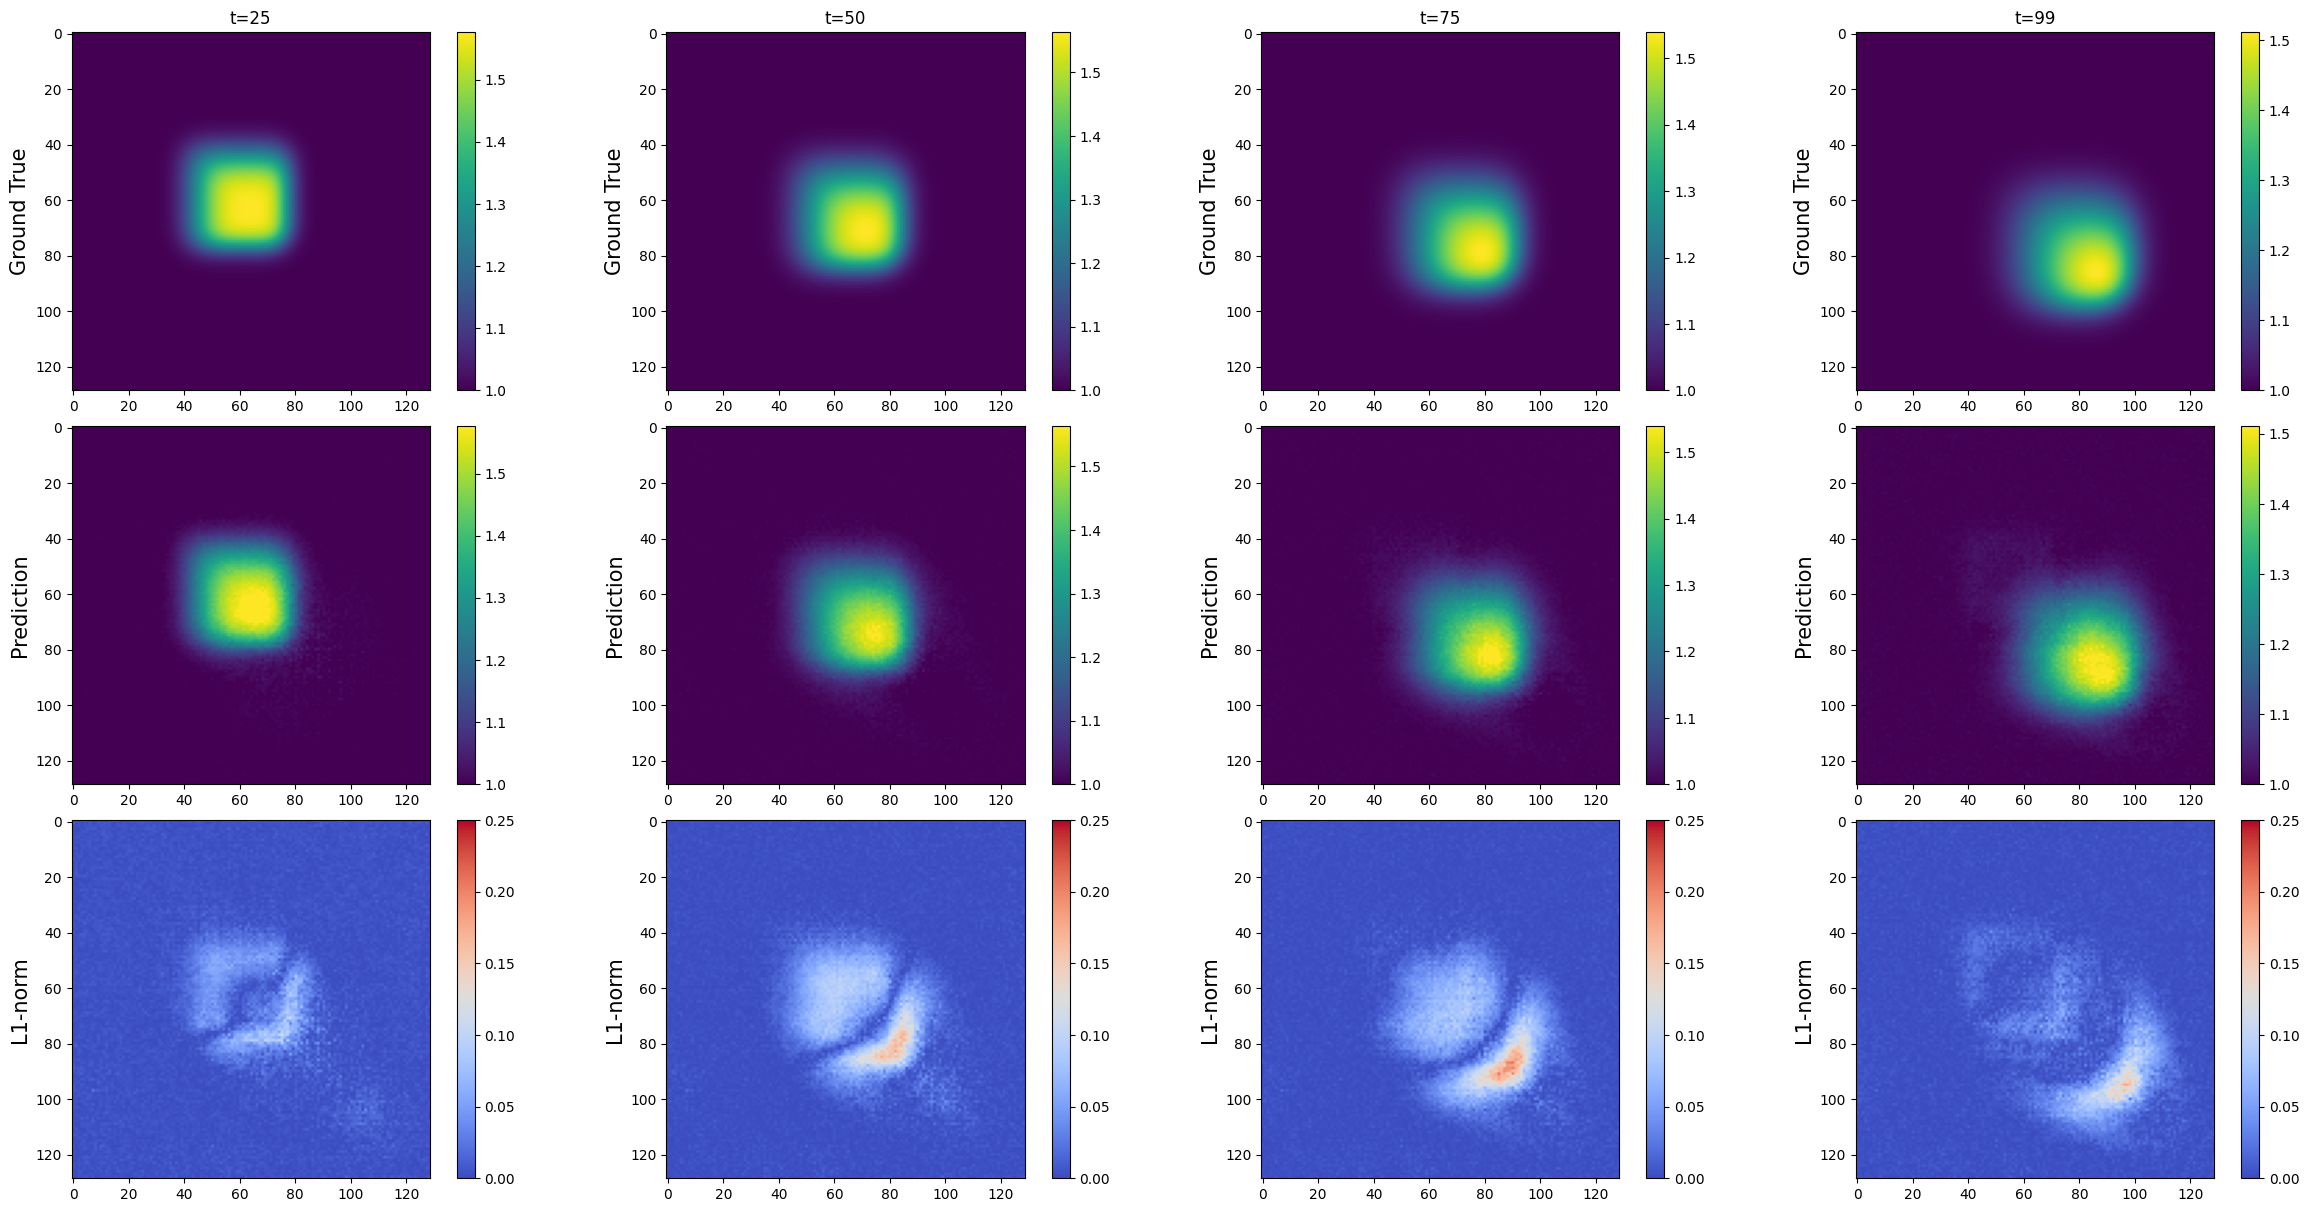

In [28]:
basic_hist = results_plot.plot_images_and_loss(test_data, basic_predictions, 0, batch_num, num, nDisplay, name='Basic')

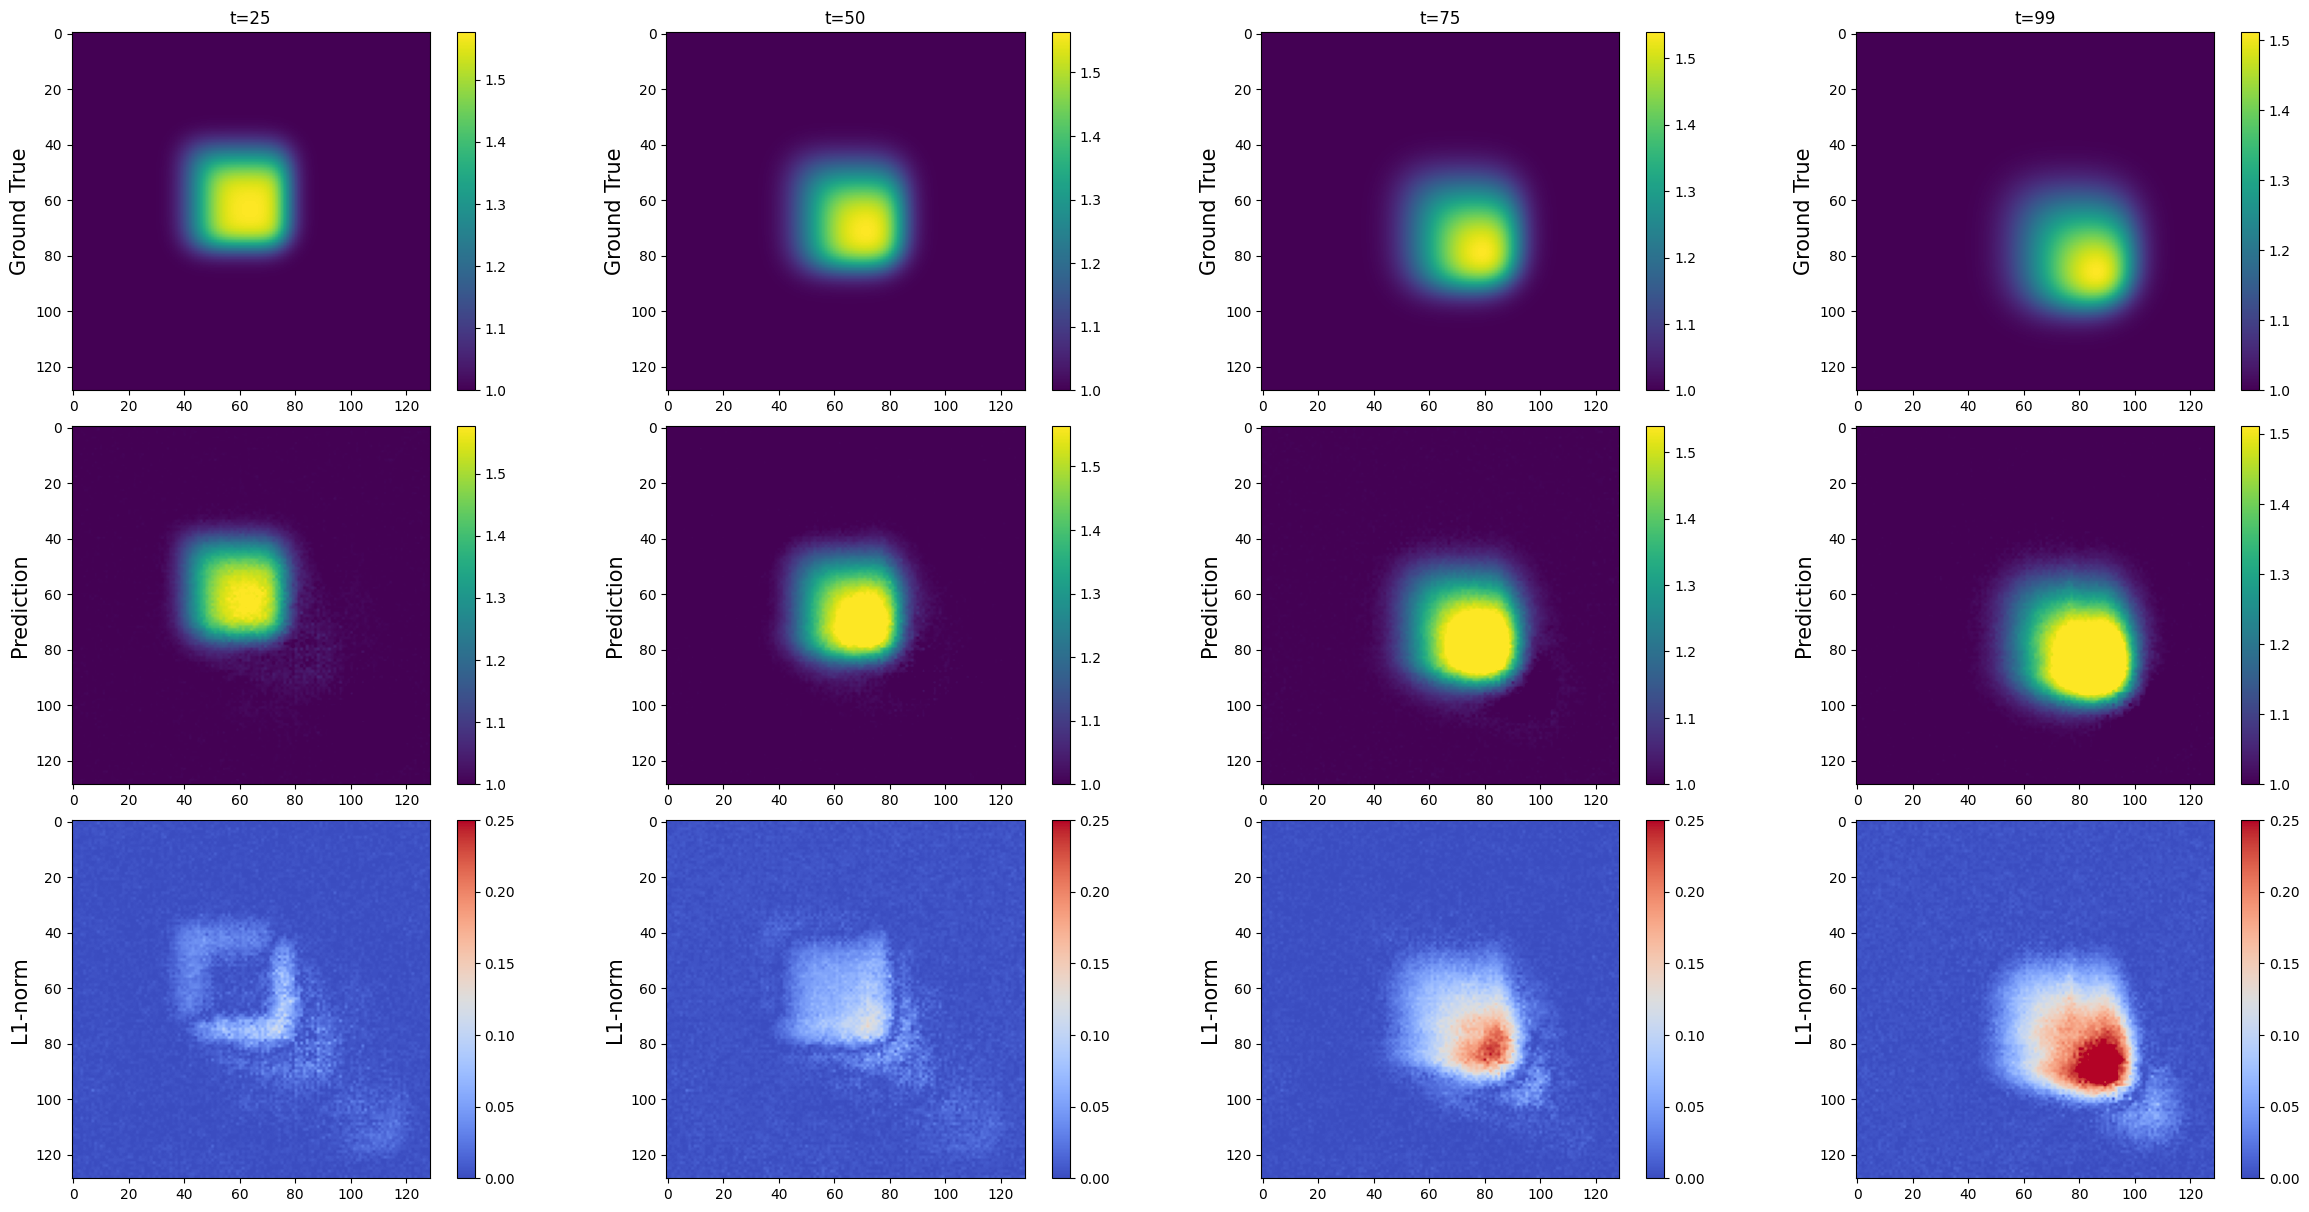

In [29]:
multidata_hist = results_plot.plot_images_and_loss(test_data, multidata_predictions, 0, batch_num, num, nDisplay, name='Multi Dataset')

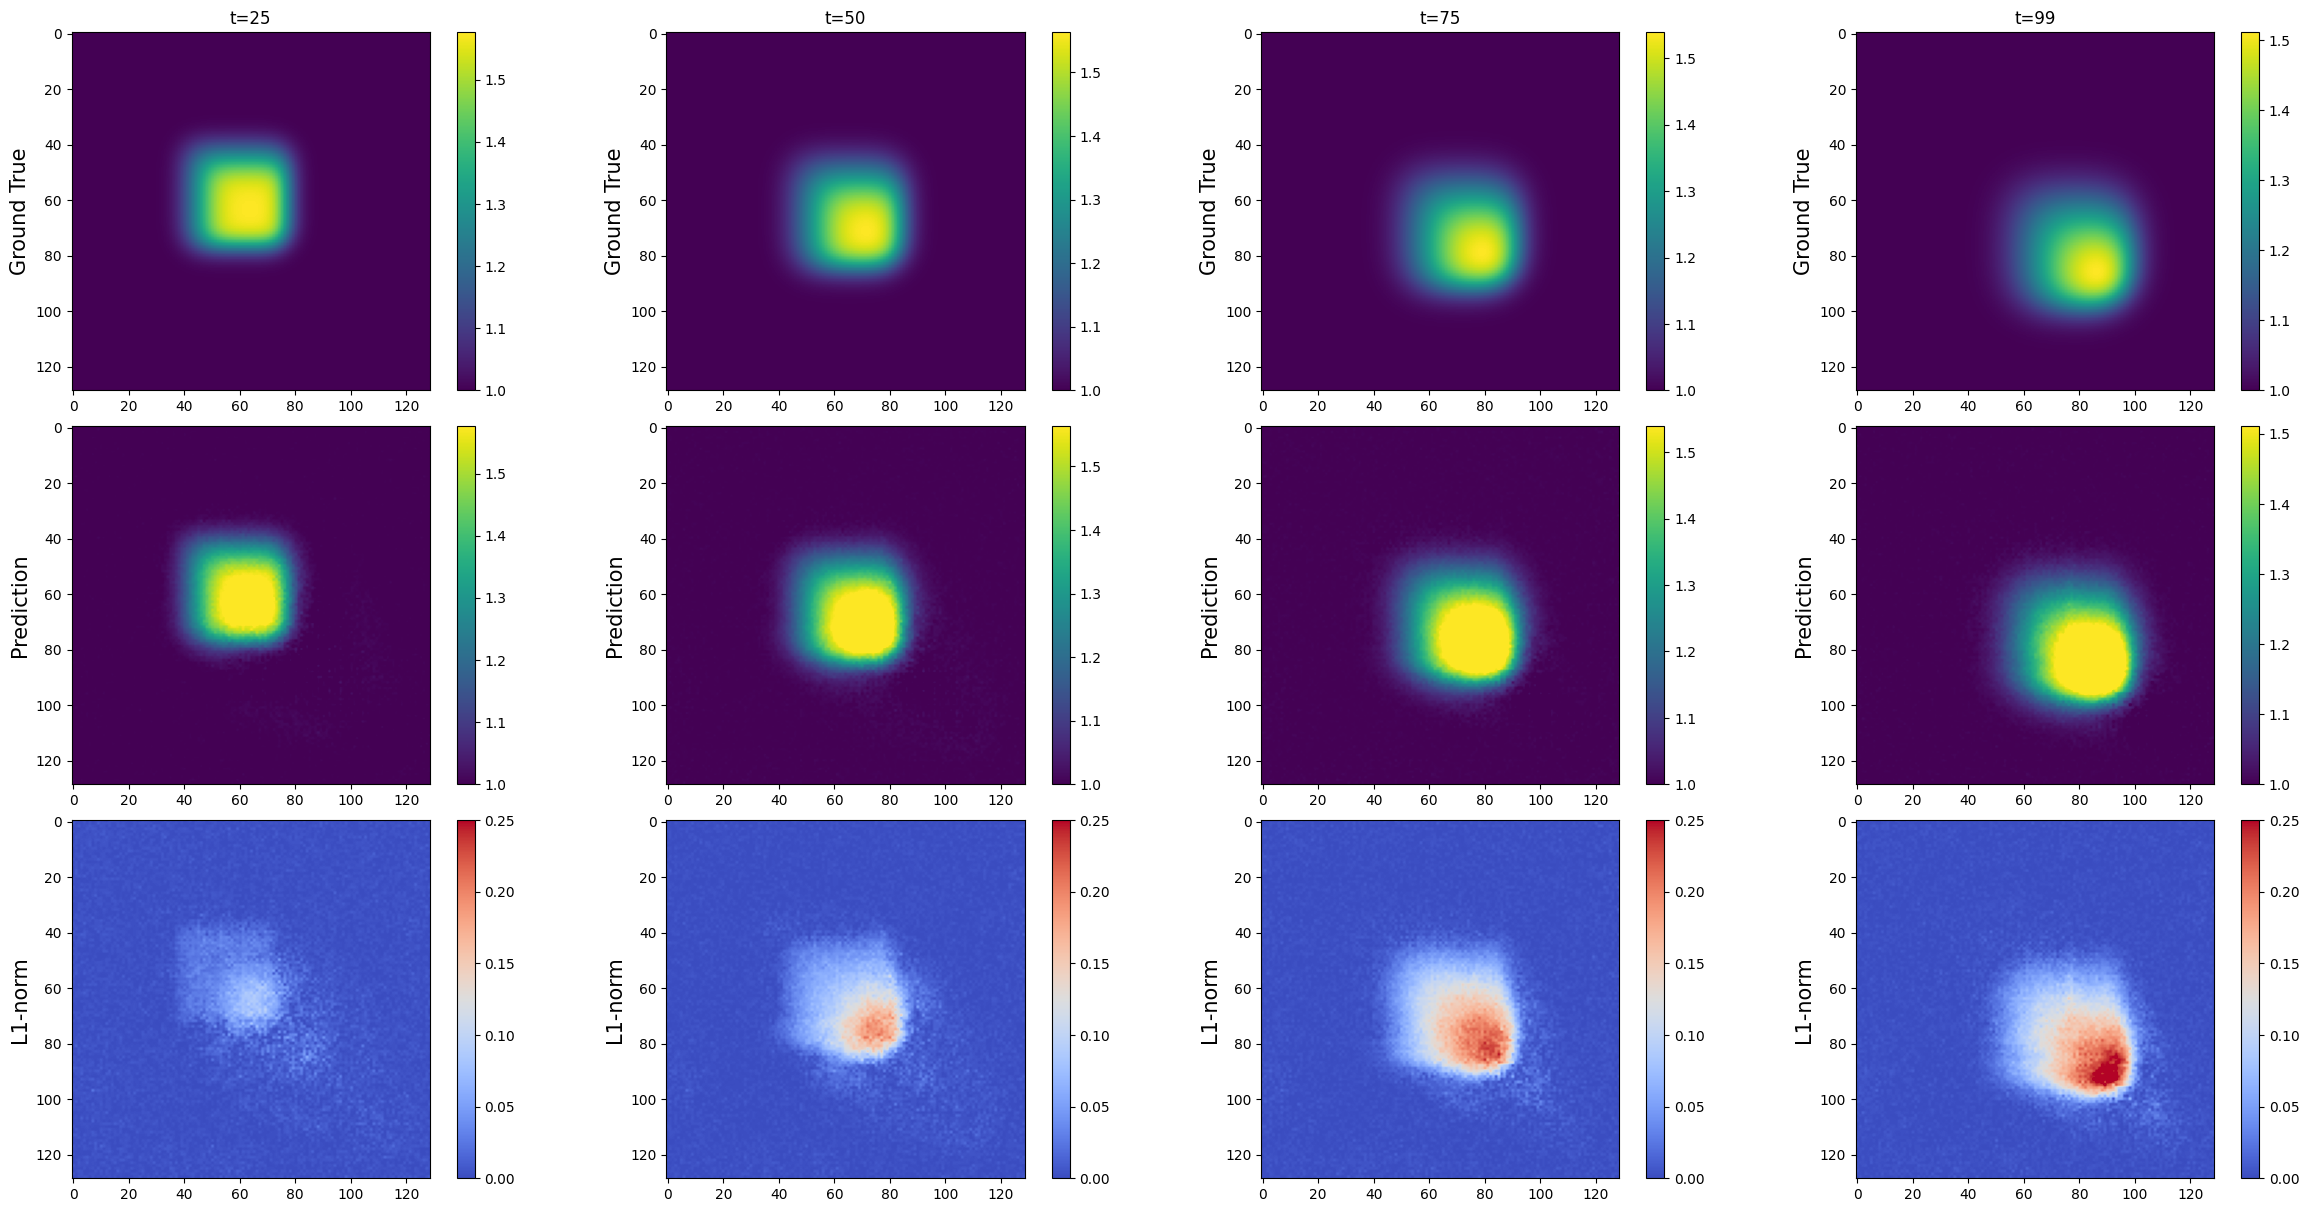

In [30]:
ec_high_hist = results_plot.plot_images_and_loss(test_data, hf_ec_predictions, 0, batch_num, num, nDisplay, name='EC in High Fidelity Cons')

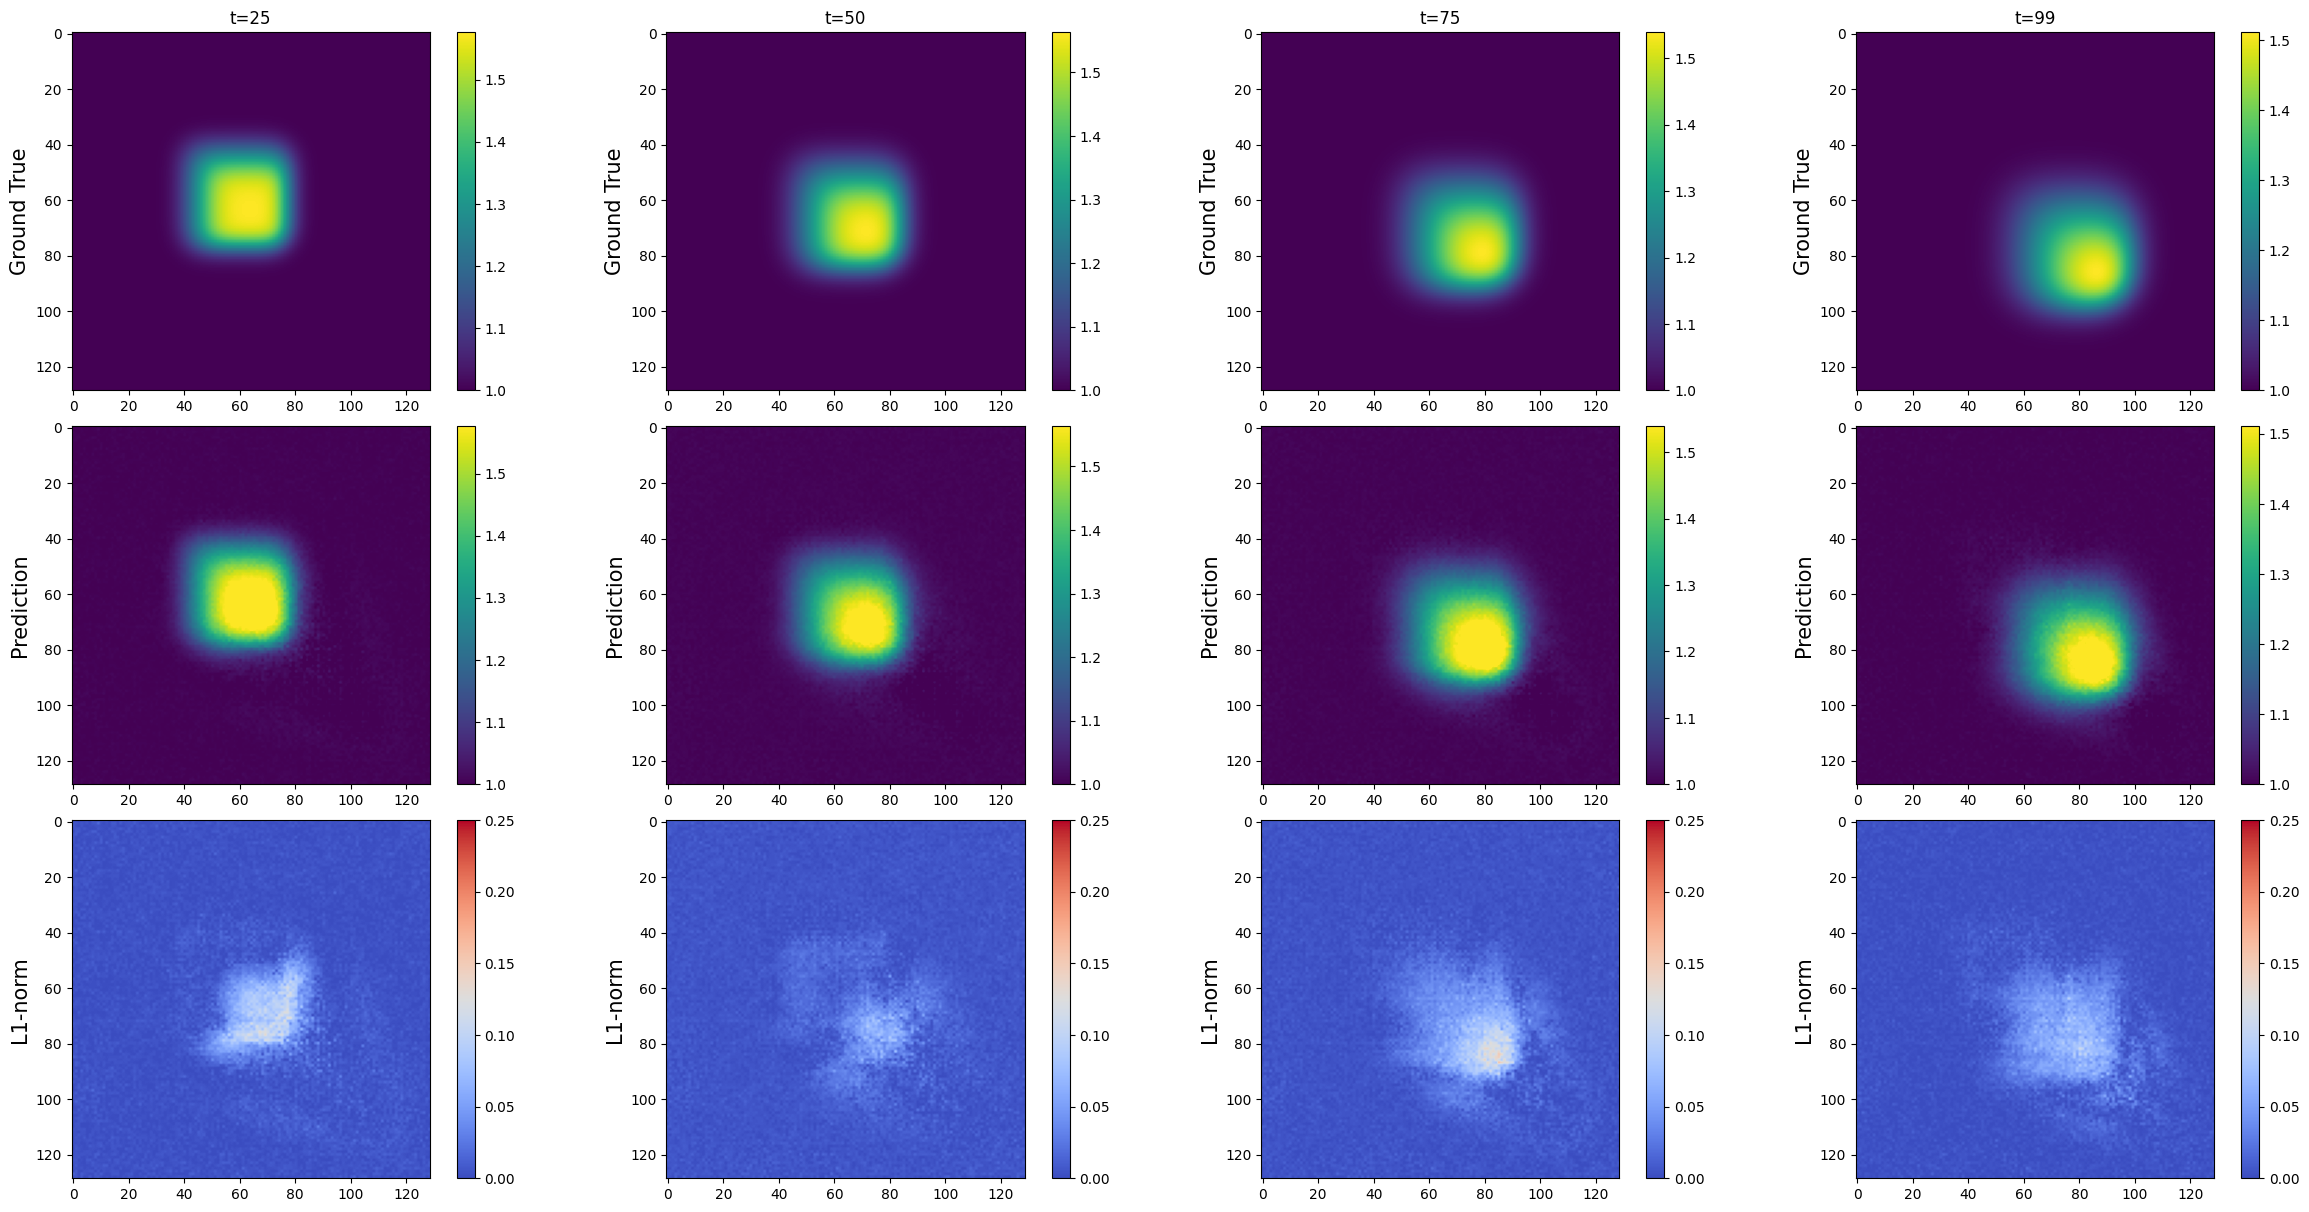

In [31]:
ec_low_hist = results_plot.plot_images_and_loss(test_data, lf_ec_predictions, 0, batch_num, num, nDisplay, name='EC in Low Fidelity Cons')

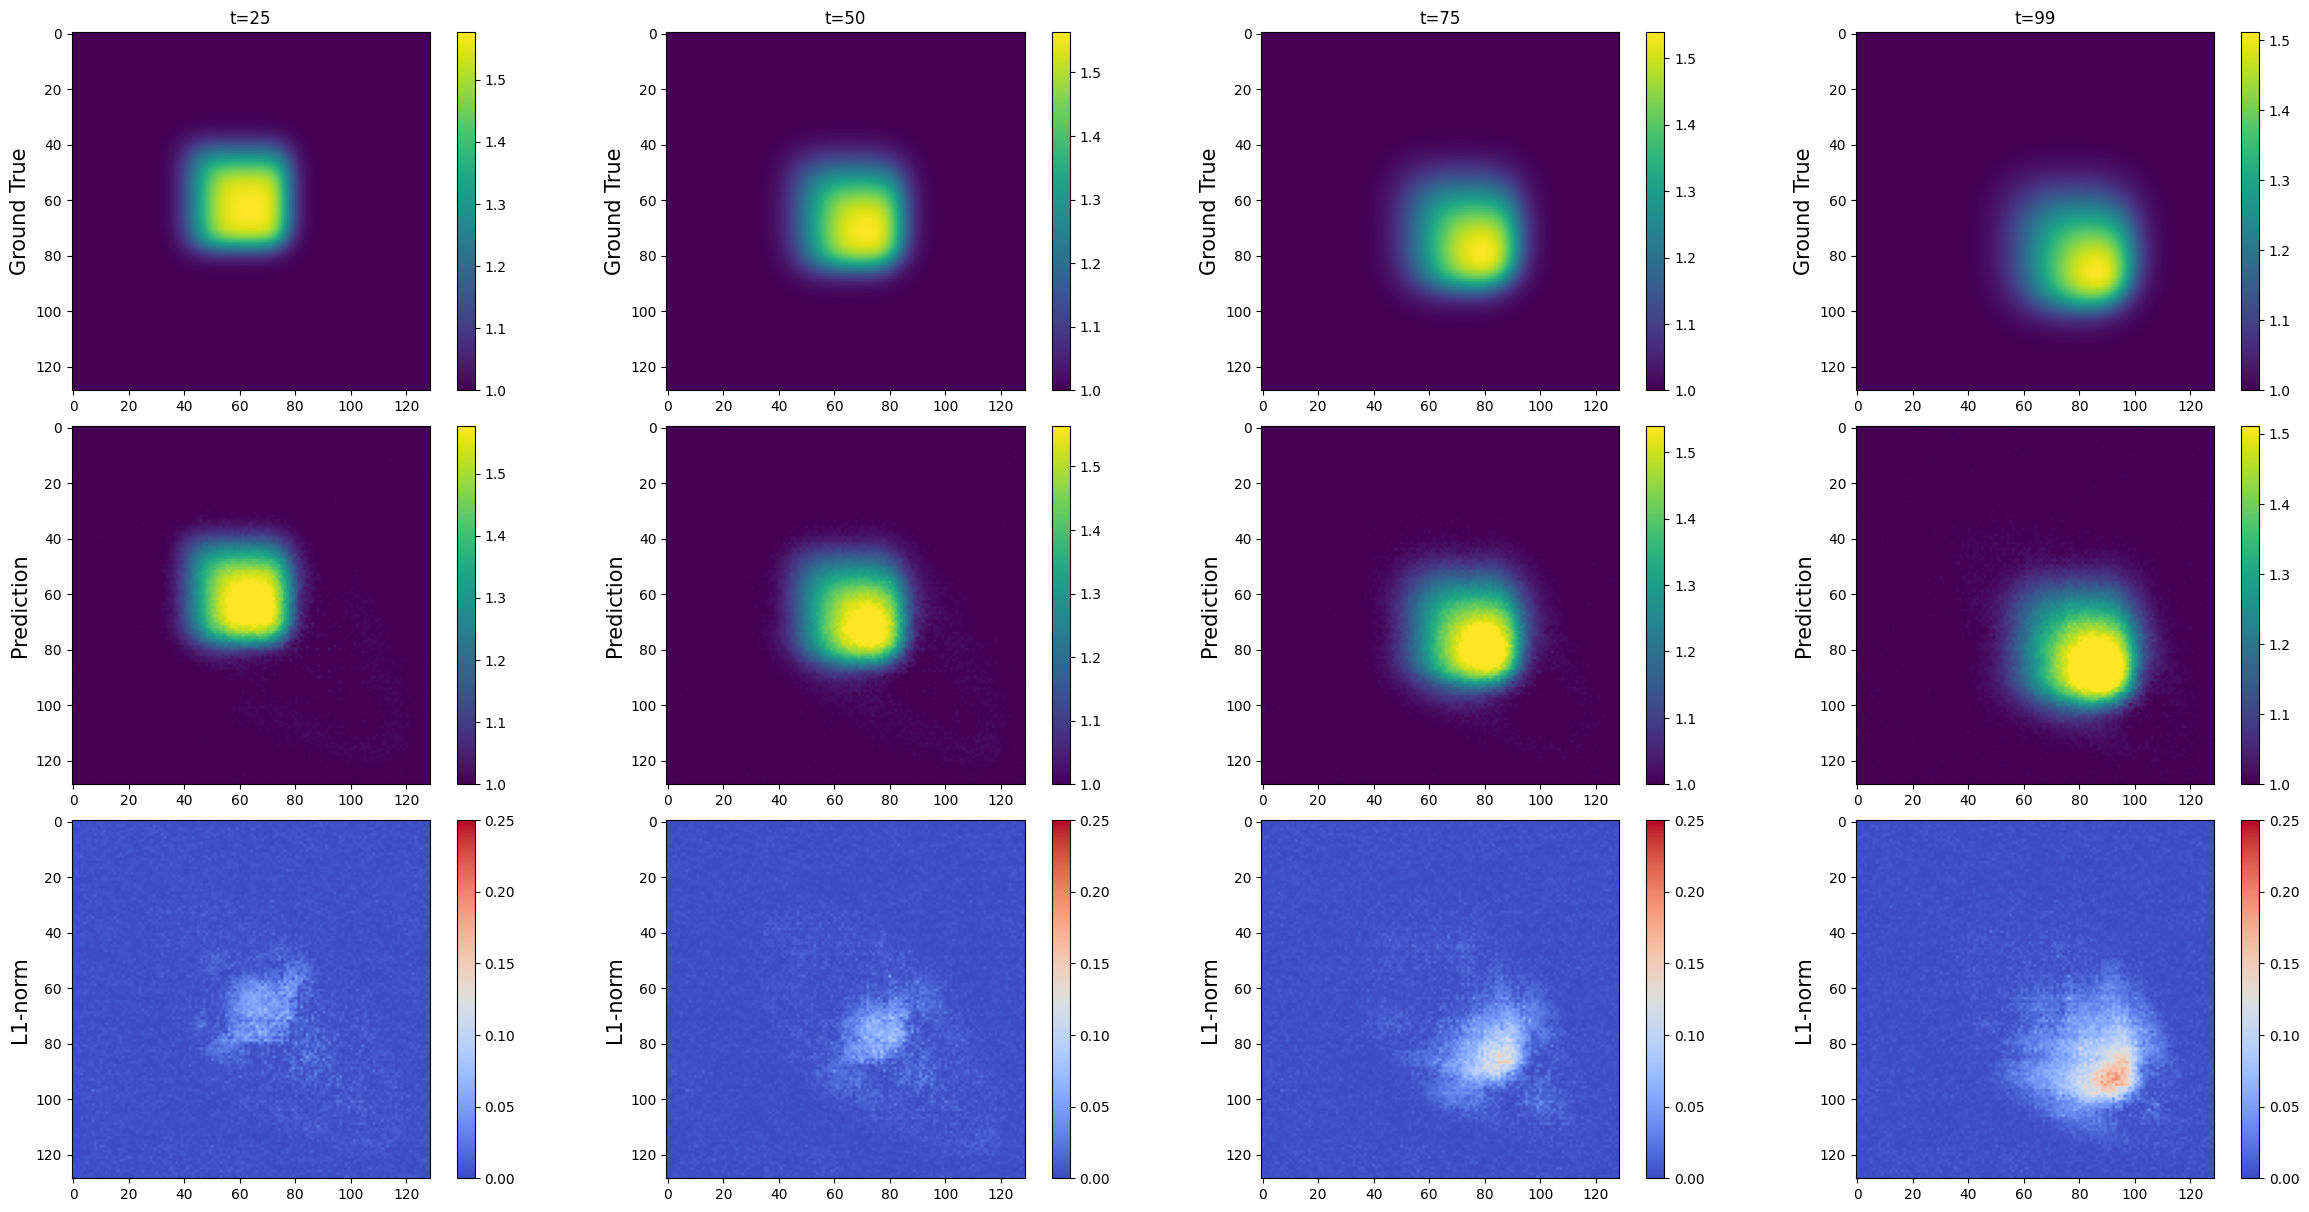

In [32]:
fo_high_hist = results_plot.plot_images_and_loss(test_data, hf_fo_predictions, 0, batch_num, num, nDisplay, name='FO in High Fidelity Cons')

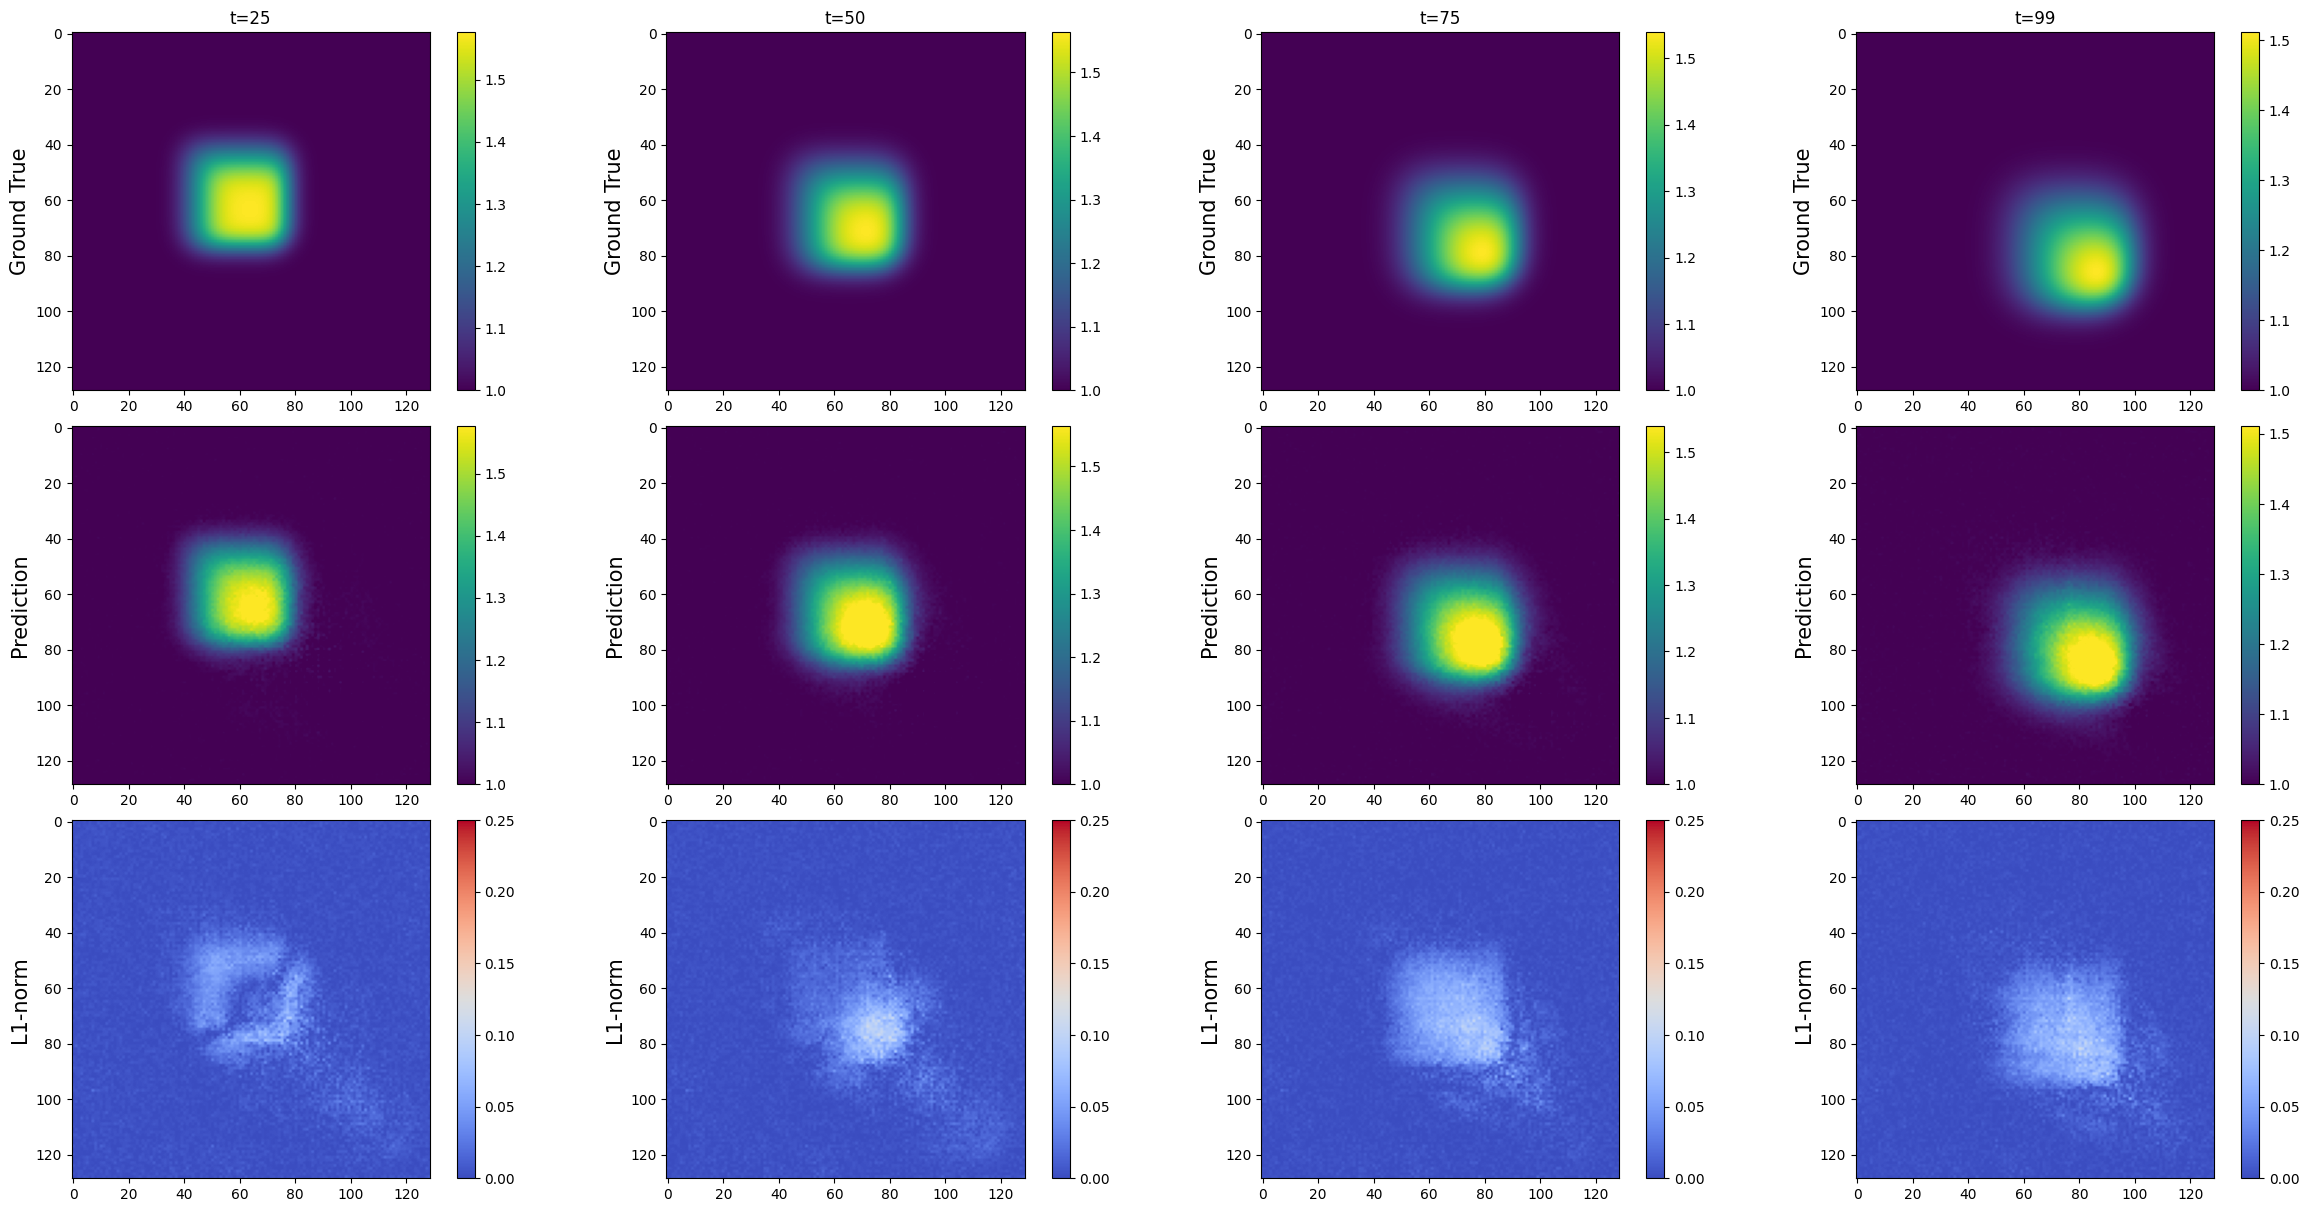

In [33]:
fo_low_hist = results_plot.plot_images_and_loss(test_data, lf_fo_predictions, 0, batch_num, num, nDisplay, name='FO in Low Fidelity Cons')

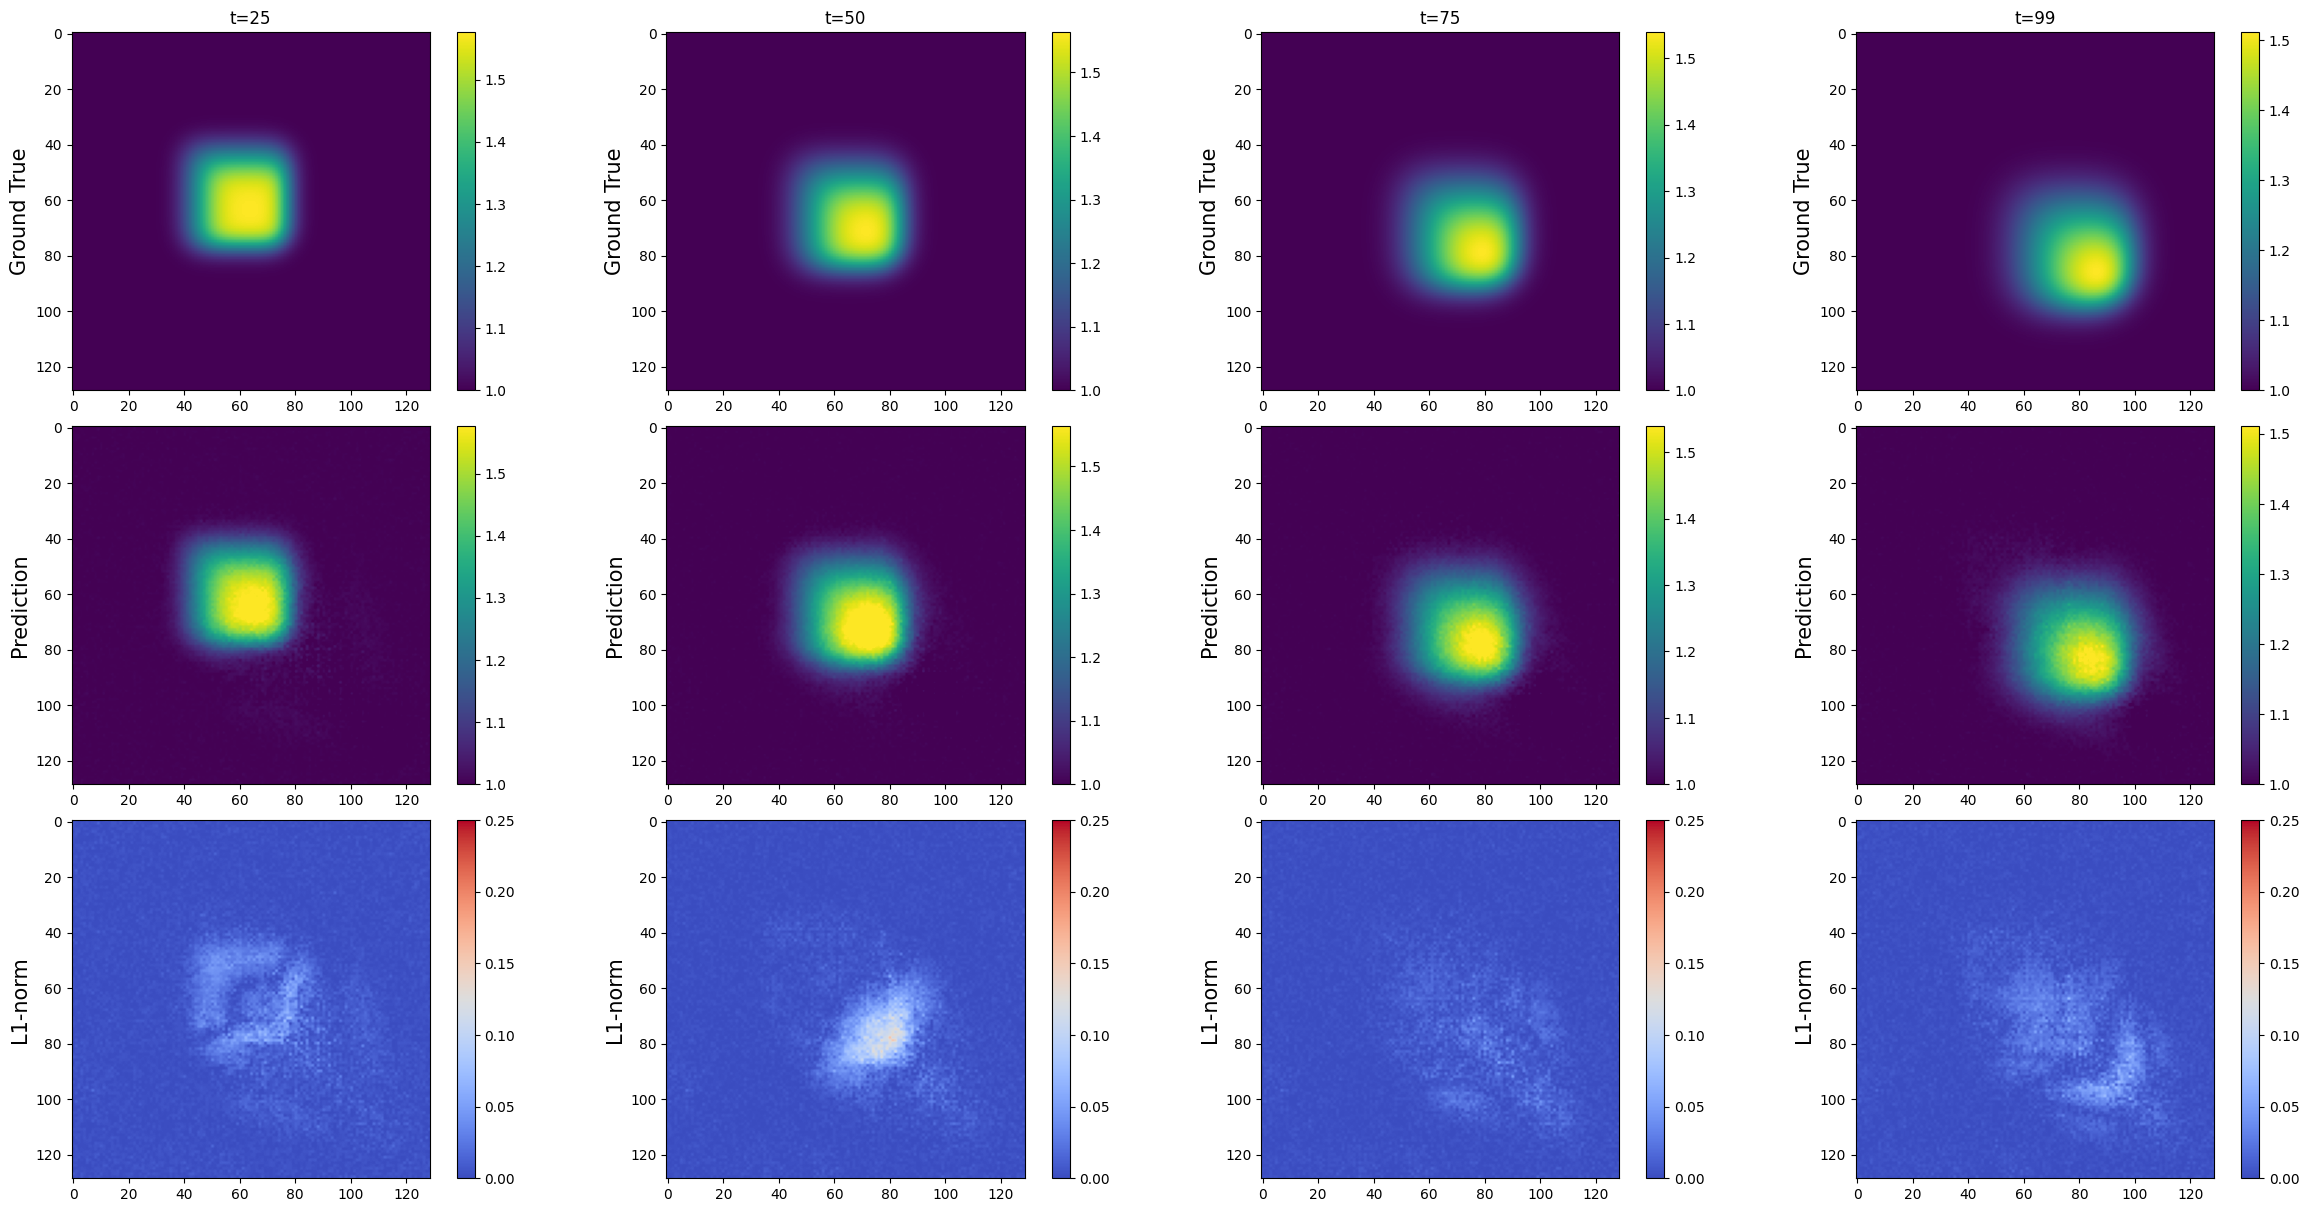

In [34]:
multi_high_hist = results_plot.plot_images_and_loss(test_data, hf_multi_predictions, 0, batch_num, num, nDisplay, name='MultiCons in High Fidelity Cons')

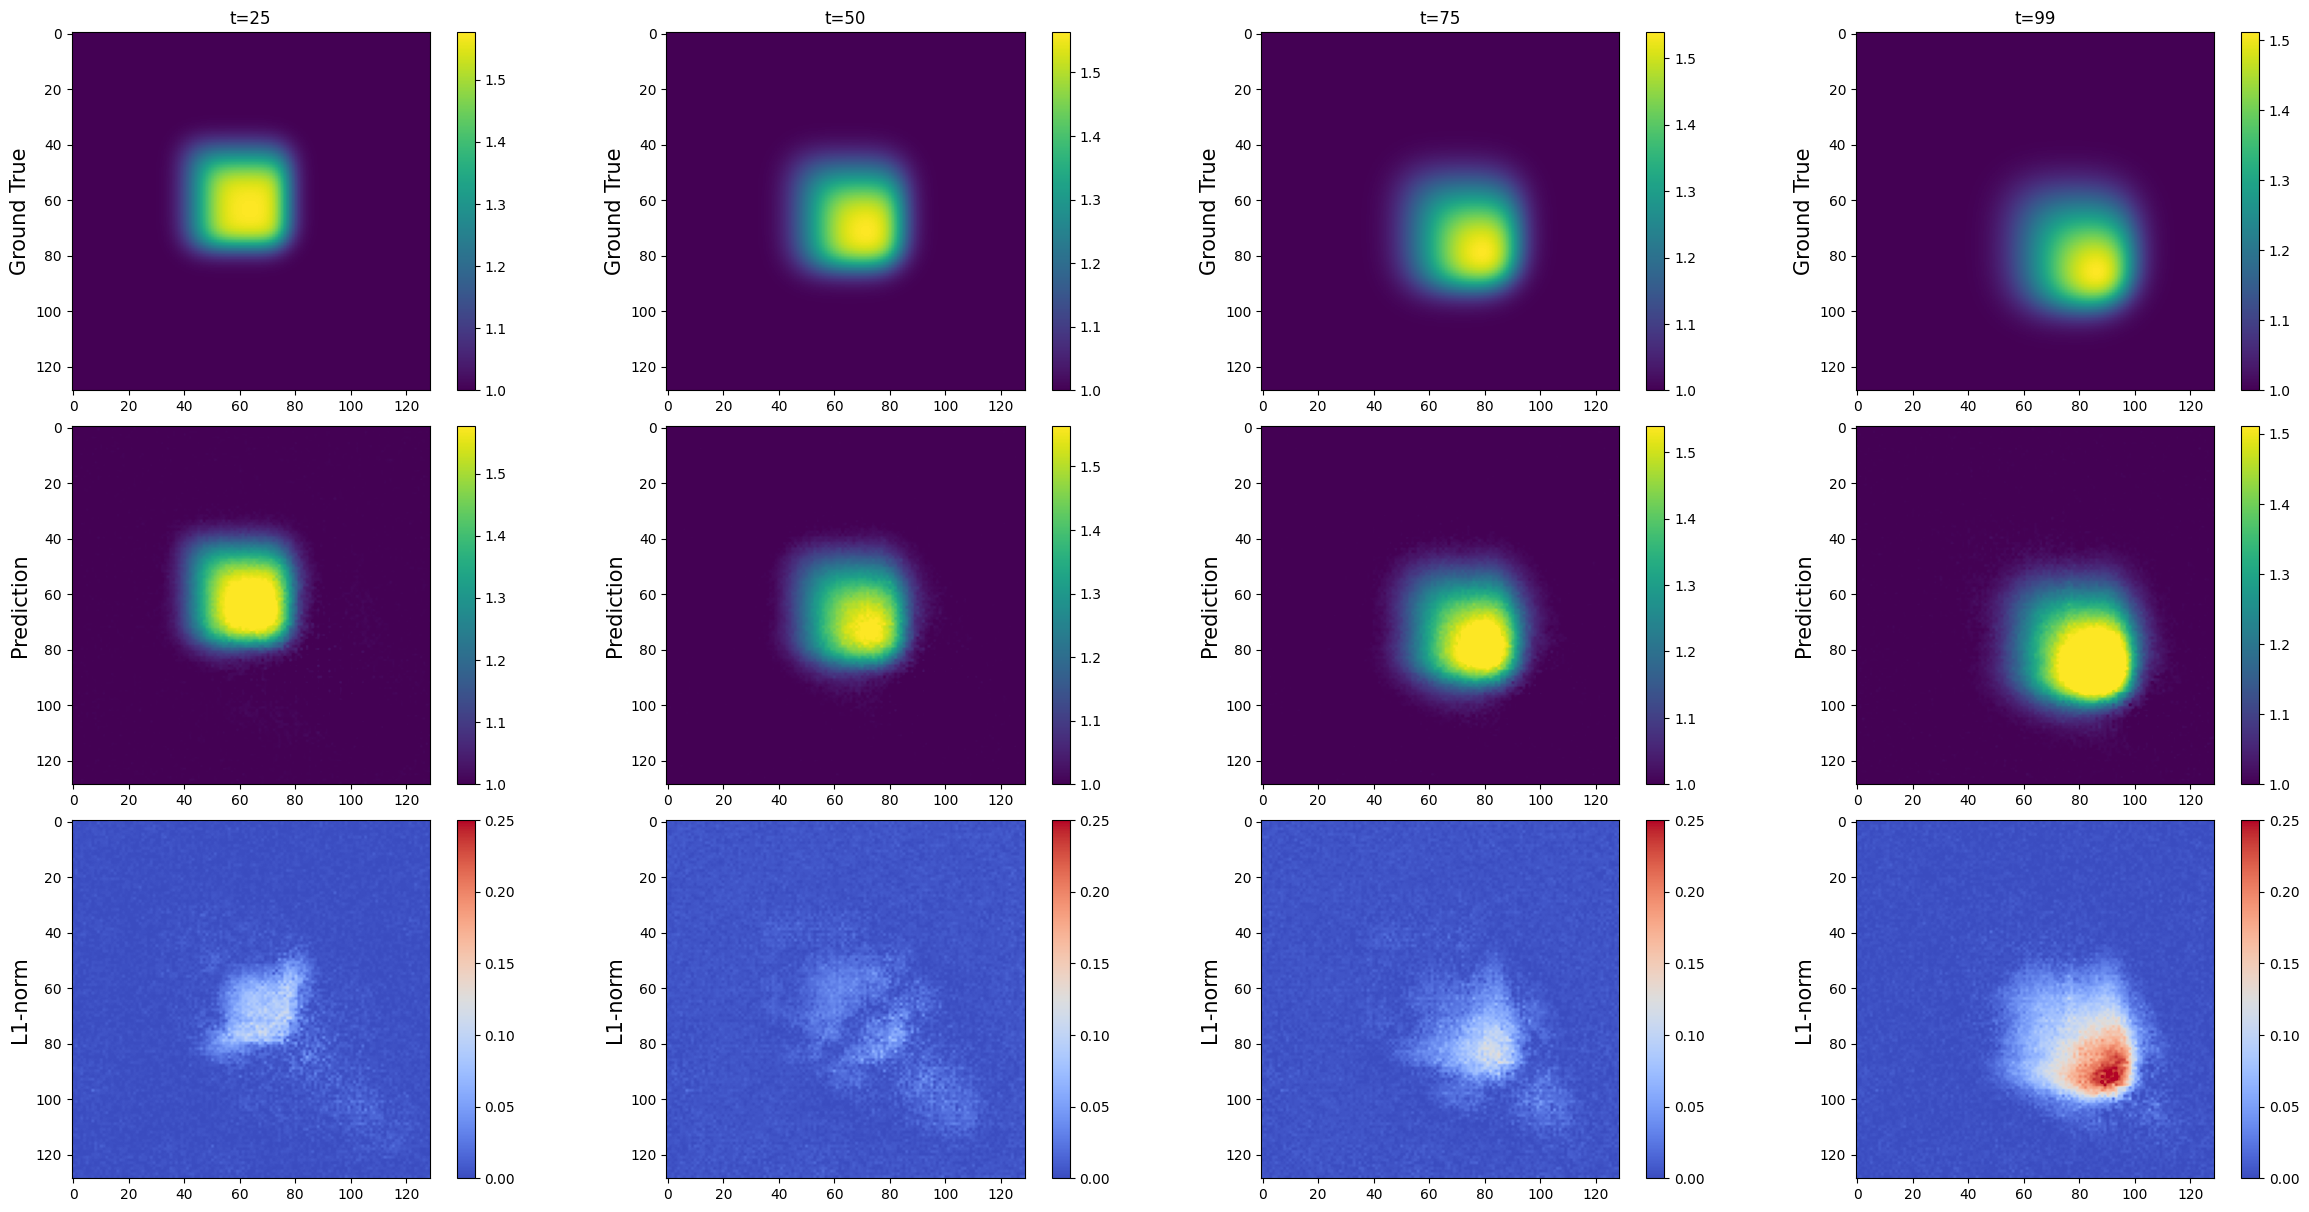

In [35]:
multi_low_hist = results_plot.plot_images_and_loss(test_data, lf_multi_predictions, 0, batch_num, num, nDisplay, name='MultiCons in Low Fidelity Cons')

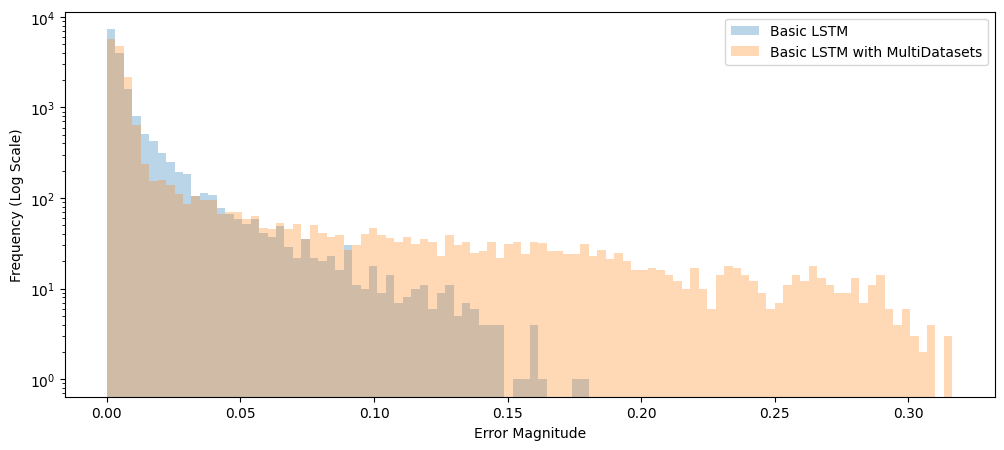

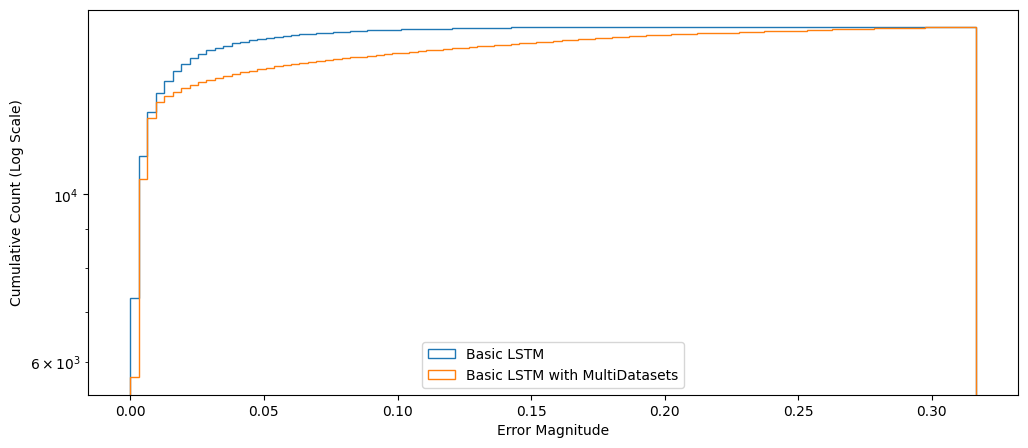

In [36]:
results_plot.plot_histograms(basic_hist[-1], multidata_hist[-1], labels=['Basic LSTM', 'Basic LSTM with MultiDatasets'])

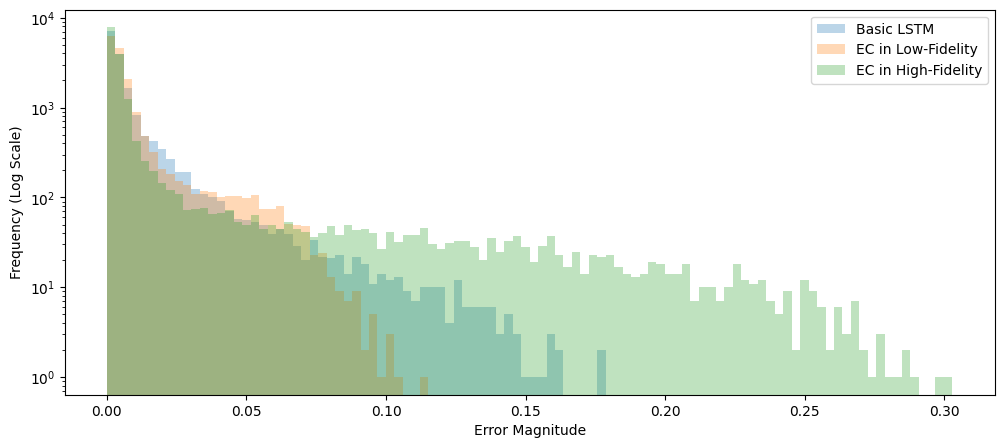

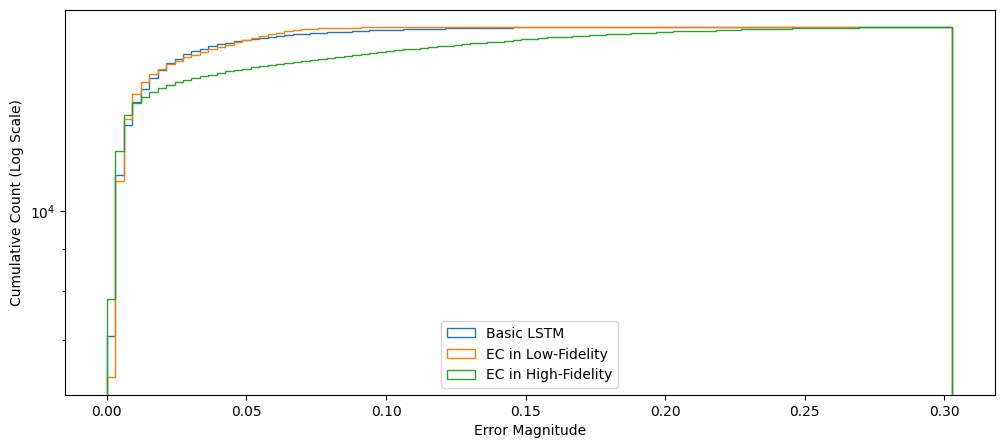

In [37]:
results_plot.plot_histograms(basic_hist[-1], ec_low_hist[-1], ec_high_hist[-1], labels=['Basic LSTM', 'EC in Low-Fidelity', 'EC in High-Fidelity'])

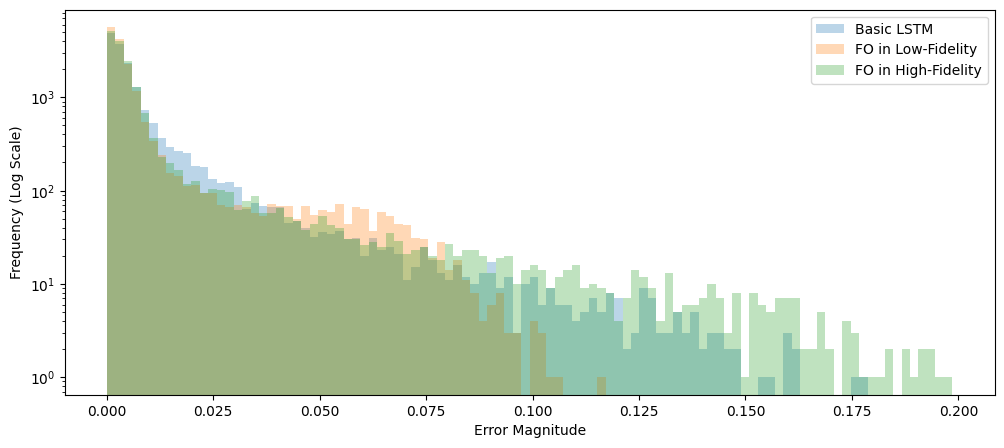

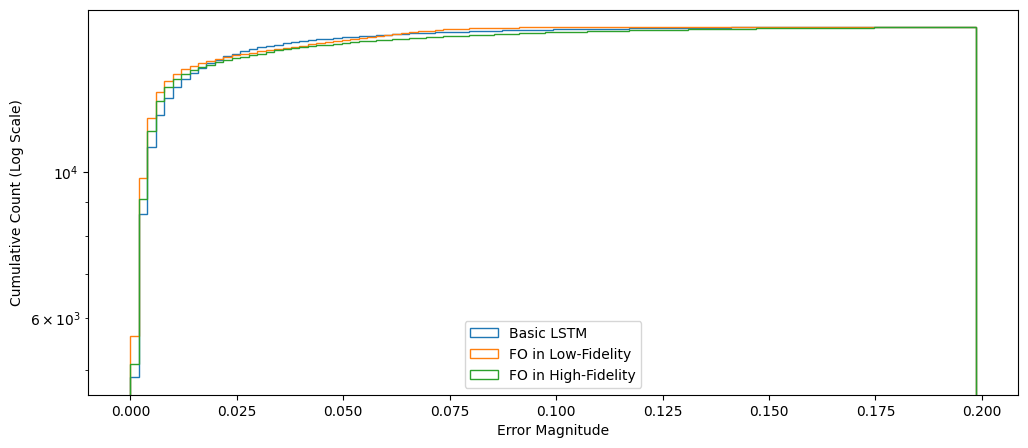

In [38]:
results_plot.plot_histograms(basic_hist[-1], fo_low_hist[-1], fo_high_hist[-1], labels=['Basic LSTM', 'FO in Low-Fidelity', 'FO in High-Fidelity'])

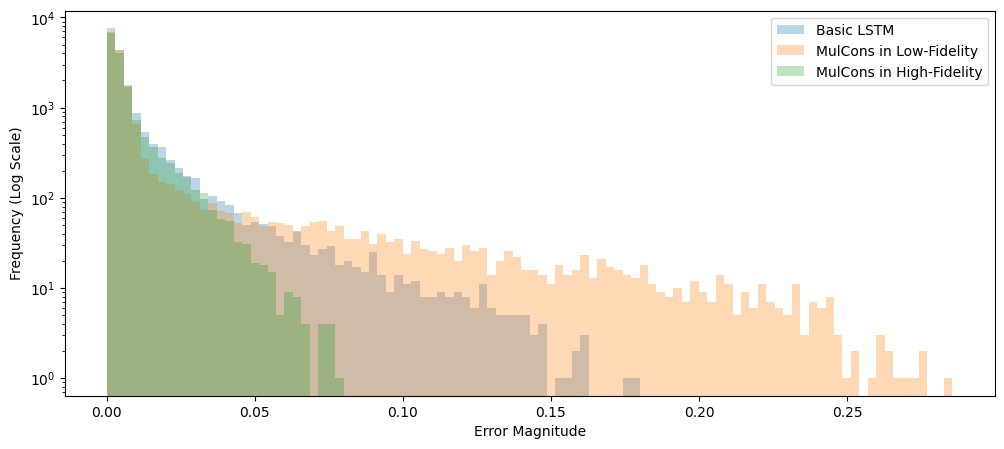

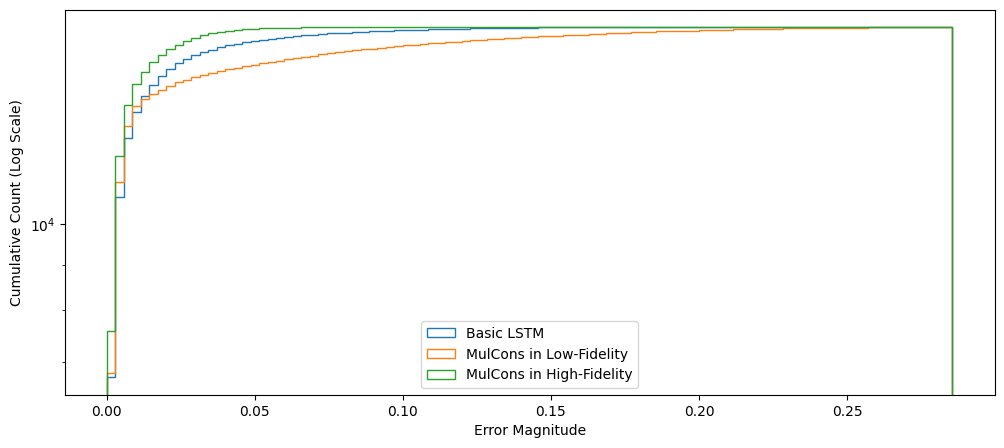

In [39]:
results_plot.plot_histograms(basic_hist[-1], multi_low_hist[-1], multi_high_hist[-1], labels=['Basic LSTM', 'MulCons in Low-Fidelity', 'MulCons in High-Fidelity'])